<a href="https://colab.research.google.com/github/aslanides/aslanides.github.io/blob/master/colabs/2019-10-10-interpolation-regime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Interpolating Regime

In this colab we'll replicate the experimental results from the paper "Reconciling modern machine learning practice and the bias-variance trade-off"
 ([Belkin et al., 2018](https://arxiv.org/abs/1812.11118)).
 
The motivation is the observation that in the modern 'deep learning' regime, we find empirically that large models generalize well even -- especially -- when trained to achieve zero loss on the training set. On the face of it, this seems to be at odds with the 'sweet spot' intuition that the bias-variance decomposition tells us. This paper uses some elegant experiments to connect these two observations -- once the number of parameters exceeds some threshold (proportional to the size of the training set) we are in the 'interpolating regime', where the extra model capacity effectively allows us to interpolate between fitting data points smoothly; since smoothness is a property of many natural data distributions, this actually results in better generalization to the test set.

We'll run two experiments: one to show the intuition with a toy example, and then one to reproduce the main result on MNIST.

## Simple experiment

In [0]:
from typing import Callable
import warnings

import numpy as np
import pandas as pd
import plotnine as gg
import sklearn

gg.theme_set(gg.theme_bw())
warnings.filterwarnings('ignore')

In [0]:
FeatureFn = Callable[[np.ndarray], np.ndarray]

def random_relu_features(num_features: int) -> FeatureFn:
  weights = np.random.randn(num_features, 2)

  def feature_fn(xs: np.ndarray) -> np.ndarray:
    n = len(xs)
    xs_with_bias = np.vstack([xs, np.ones(n)])
    return np.maximum(np.dot(weights, xs_with_bias), 0).T
  
  return feature_fn


def polynomial_features(num_features: int) -> FeatureFn:

  def feature_fn(xs: np.ndarray) -> np.ndarray:
    return np.array([xs**n for n in range(num_features)]).T

  return feature_fn

In [0]:
# Train model
def train_and_evaluate(
    train_xs: np.ndarray,
    train_ys: np.ndarray,
    test_xs: np.ndarray,
    feature_fn: FeatureFn,
    ) -> np.ndarray:

  train_features = feature_fn(train_xs)
  model = sklearn.linear_model.LinearRegression()
  model.fit(train_features, train_ys)

  test_features = feature_fn(test_xs) 
  predictions = model.predict(test_features)

  return predictions

In [0]:
# Make some synthetic data.
num_data = 10
train_xs = np.linspace(-3, 3, num=num_data)
test_xs = np.linspace(-3, 3, num=1000)
train_ys = np.random.randn(num_data)
train_df = pd.DataFrame({'x': train_xs, 'y': train_ys})

# Train different models.
pred_df = pd.DataFrame()
for num_features in [3, 20, 1000]:
  feature_fn = random_relu_features(num_features)
  preds = train_and_evaluate(train_xs, train_ys, test_xs, feature_fn=feature_fn)
  df = pd.DataFrame({
        'x': test_xs,
        'y': preds,
        'num_features': num_features,
  })
  pred_df = pd.concat([pred_df, df])

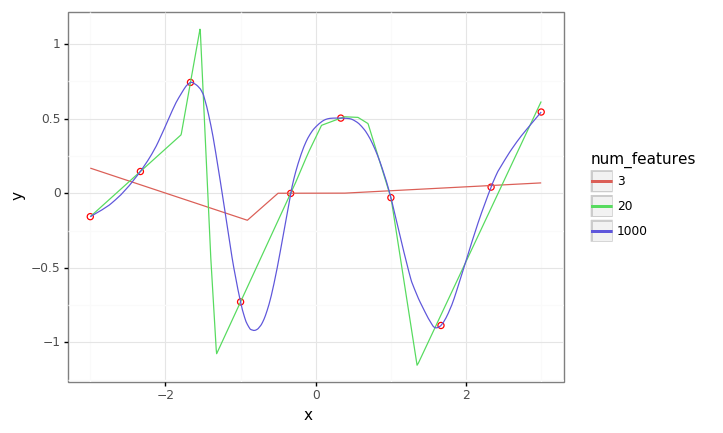

<ggplot: (8764140769316)>

In [69]:
plot = (gg.ggplot(train_df)
     + gg.aes(x='x', y='y')
     + gg.geom_point(size=2, color='red', fill='white')
     + gg.geom_line(data=pred_df, mapping=gg.aes(color='factor(num_features)'))
     + gg.labs(color='num_features')
)
plot

## MNIST experiment

In [0]:
! pip install --quiet dm-sonnet

In [0]:
# @title Imports

import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds

In [0]:
# Hyperparameters and training setup.

num_data = int(4e3)
num_epochs = 1000
batch_size = 100
batch_size_eval = 1000
learning_rate = 1e-3
num_classes = 10  # MNIST.
input_dim = 784  # MNIST.

In [0]:
# Dataset.

data_train = tfds.load('mnist', split=tfds.Split.TRAIN, as_supervised=True)
data_train = data_train.take(num_data)
data_train = data_train.shuffle(num_data)
data_train = data_train.batch(batch_size)

data_eval = {
    'train': tfds.load('mnist', split=tfds.Split.TRAIN, as_supervised=True).batch(batch_size_eval),
    'test': tfds.load('mnist', split=tfds.Split.TEST, as_supervised=True).batch(batch_size_eval),
}

In [54]:
results = []
for num_parameters in np.logspace(start=3, stop=5, num=10):

  # Create model.
  num_hidden = int((num_parameters - num_classes) / (1 + input_dim + num_classes))
  model = snt.Sequential([
      snt.Flatten(),
      snt.Linear(num_hidden),
      tf.nn.relu,
      snt.Linear(num_classes),
  ])

  # Create Adam optimizer.
  optimizer = snt.optimizers.Adam(learning_rate)

  # Initialize model weights.
  dummy_images, _ = iter(data_train).next()
  dummy_images = tf.image.convert_image_dtype(dummy_images, dtype=tf.float32)
  model(dummy_images)

  @tf.function
  def train(images: tf.Tensor,
            labels: tf.Tensor) -> tf.Tensor:
    images = tf.image.convert_image_dtype(images, dtype=tf.float32)
    with tf.GradientTape() as tape:
      logits = model(images)
      loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply(gradients, model.trainable_variables)
    return tf.reduce_mean(loss)

  @tf.function
  def evaluate(images: tf.Tensor, labels: tf.Tensor) -> tf.Tensor:
    images = tf.image.convert_image_dtype(images, dtype=tf.float32)
    logits = model(images)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(loss)

  # Training.
  for epoch in range(num_epochs):
    for images, labels in data_train:
      train(images, labels)
 
  # Evaluation.
  for split, dataset in data_eval.items():
    images, labels = iter(dataset).next()
    loss = evaluate(images, labels)

    result = {
        'num_parameters': num_parameters,
        'split': split,
        'epoch': epoch,
        'loss': loss.numpy(),
    }
    print(result)
    results.append(result)

df = pd.DataFrame(results)

{'num_parameters': 1000.0, 'split': 'train', 'epoch': 999, 'loss': 2.3039355}
{'num_parameters': 1000.0, 'split': 'test', 'epoch': 999, 'loss': 2.3035538}
{'num_parameters': 1668.100537200059, 'split': 'train', 'epoch': 999, 'loss': 0.79635864}
{'num_parameters': 1668.100537200059, 'split': 'test', 'epoch': 999, 'loss': 1.5306188}
{'num_parameters': 2782.559402207126, 'split': 'train', 'epoch': 999, 'loss': 0.31688783}
{'num_parameters': 2782.559402207126, 'split': 'test', 'epoch': 999, 'loss': 1.2448906}
{'num_parameters': 4641.588833612777, 'split': 'train', 'epoch': 999, 'loss': 0.0021776722}
{'num_parameters': 4641.588833612777, 'split': 'test', 'epoch': 999, 'loss': 2.1002421}
{'num_parameters': 7742.63682681127, 'split': 'train', 'epoch': 999, 'loss': 1.4185904e-08}
{'num_parameters': 7742.63682681127, 'split': 'test', 'epoch': 999, 'loss': 2.5922587}
{'num_parameters': 12915.496650148827, 'split': 'train', 'epoch': 999, 'loss': 1.3196438e-07}
{'num_parameters': 12915.49665014882

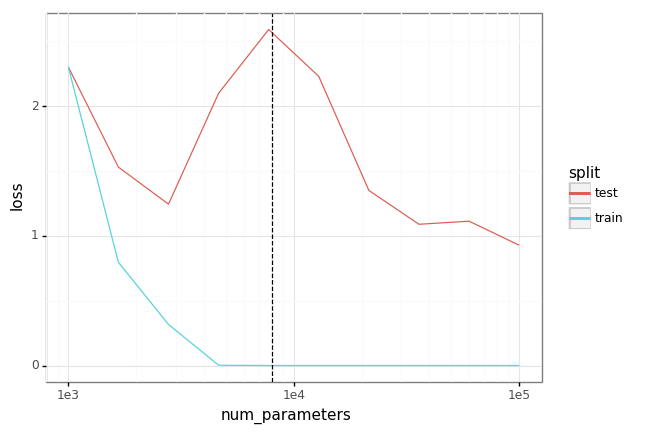

<ggplot: (8764140848083)>

In [64]:
plot = (gg.ggplot(df)
     + gg.aes(x='num_parameters', y='loss', color='split')
     + gg.geom_line()
     + gg.scale_x_log10()
     + gg.geom_vline(gg.aes(xintercept=num_data*2), linetype='dashed')
)

plot